In [8]:
from functools import cached_property
from mlflux.predictor import FluxANNs
import torch
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from mlflux.datafunc import data_split_psd
from mlflux.ann import RealFluxDataset

import pickle

%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [2]:
psd = xr.load_dataset('../../data/Processed/psd_wave.nc')

# 77, 69, 83, 78, 87, 72, 71, 68, 67, 73
split1 = [[69, 83, 78, 87, 72, 71, 68, 67, 73], [77], [77]]
split2 = [[77, 83, 78, 87, 72, 71, 68, 67, 73], [69], [69]]
split3 = [[77, 69, 78, 87, 72, 71, 68, 67, 73], [83], [83]]
split4 = [[77, 69, 83, 78, 68, 67, 73], [87, 72, 71], [87, 72, 71]]
split5 = [[77, 69, 83, 78, 87, 72, 71, 67, 73], [68], [68]]
split6 = [[77, 69, 83, 68, 87, 72, 71], [78, 67, 73], [78, 67, 73]]
split_ensem = [split1, split2, split3, split4, split5, split6]

In [6]:
psd

<xarray.Dataset>
Dimensions:  (time: 10073)
Coordinates:
  * time     (time) datetime64[ns] 1996-12-22T19:00:00.288000 ... 2016-04-13T...
Data variables: (12/26)
    taucx    (time) float64 0.1895 0.6395 0.3934 ... 0.07723 0.07373 0.08168
    taucy    (time) float64 0.0333 0.1182 -0.023 ... -0.06492 -0.02255 -0.0589
    hsc      (time) float64 -29.54 -100.4 -60.81 -142.7 ... -5.808 1.075 -13.14
    hlc      (time) float64 -99.11 -180.2 -153.9 -218.3 ... -39.32 -43.95 -109.2
    U        (time) float64 12.14 16.7 16.75 17.0 ... 9.779 8.903 8.239 8.543
    tsea     (time) float64 7.569 11.82 11.86 11.91 ... 11.43 10.9 11.38 12.66
    ...       ...
    plp0     (time) float64 35.55 111.3 111.7 112.0 112.3 ... 0.0 0.0 0.0 0.0
    pdir0    (time) float64 39.06 72.15 72.69 73.58 74.38 ... 0.0 0.0 0.0 0.0
    phs1     (time) float64 0.121 0.6146 0.5992 0.5875 ... 3.759 3.677 3.366
    plp1     (time) float64 90.67 162.9 162.3 161.2 ... 378.4 363.1 356.7 343.2
    pdir1    (time) float64 114.4 220.1 219.3 219.0 ... 238.7 236.6 236.1 235.3
    wdir     (time) float64 75.04 68.66 65.81 66.5 ... 284.7 282.9 270.4 283.4

In [12]:
def plot_feature(ax, X, Y_truth, Y_pred, LEGEND=True):
    mse = torch.mean((Y_truth-Y_pred)**2)
    r2 = 1 - mse/torch.var(Y_truth)
    ax.plot(X,Y_truth, 'o', mfc="None", markeredgewidth=0.5, markersize=4, label='Measurements')
    ax.plot(X,Y_pred, 'o', mfc="None", markeredgewidth=0.5, markersize=4, label='ANN Prediction (mean)')
    if LEGEND:
        ax.legend(fancybox=False)

### Reload one-output trained model and make predictions 

In [3]:
''' Predictor with four inputs and four outputs, and with fixed first layer taking temperature difference. '''
from mlflux.ann import ANNdiff   
class Fluxdiff(FluxANNs):
    def __init__(self,params={}):
        super().__init__(params)
        self.mean_func = ANNdiff(**self.mean_ann_para)
        self.var_func = ANNdiff(**self.var_ann_para)  

#### Momentum flux

In [ ]:
i = 5
filename = "../../saved_model/full_anns_diff_momentum_3layers_split%g.p" %(i+1)
with open(filename, "rb") as input_file:
    model = pickle.load(input_file)

Text(0, 0.5, 'Momentum flux $\\tau_x \\; [N/m^2]$')

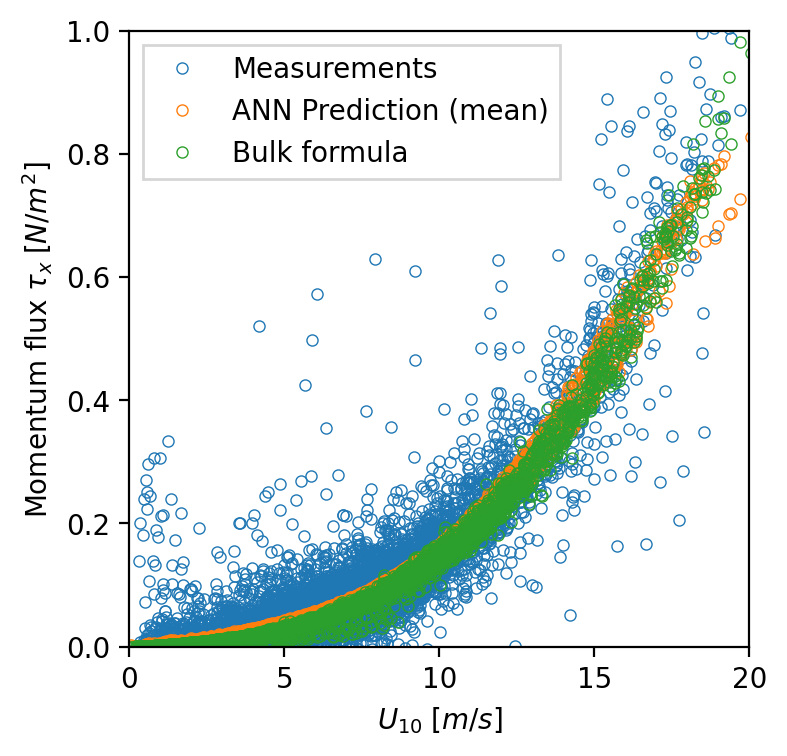

In [8]:
# no weights
def sample_weights(x):
    return np.where(x > 18, 1.0, 1.0)

fig = plt.figure(figsize=[4,4],dpi=200); ax = plt.gca()
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['taucx'], 'bkeys':['taubx']}
vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)
plot_feature(ax, vd.X[:,0], vd.Y, model.pred_mean(vd.X).detach().numpy())
ax.plot(vd.X[:,0], vd.Bulk, 'o', mfc="None", markeredgewidth=0.5, markersize=4, label='Bulk formula')

ax.legend(fancybox=False)
ax.set_ylim([0,1]); ax.set_xlim([0,20])
ax.set_xlabel('$U_{10} \; [m/s]$'); ax.set_ylabel(r'Momentum flux $\tau_x \; [N/m^2]$')

#### Heat Flux

In [30]:
i = 0
filename = "../../saved_model/full_anns_diff_sensible_3layers_split%g.p" %(i+1)
with open(filename, "rb") as input_file:
    model = pickle.load(input_file)

Text(0, 0.5, 'Sensible heat flux $Q_s \\; [W/m^2]$')

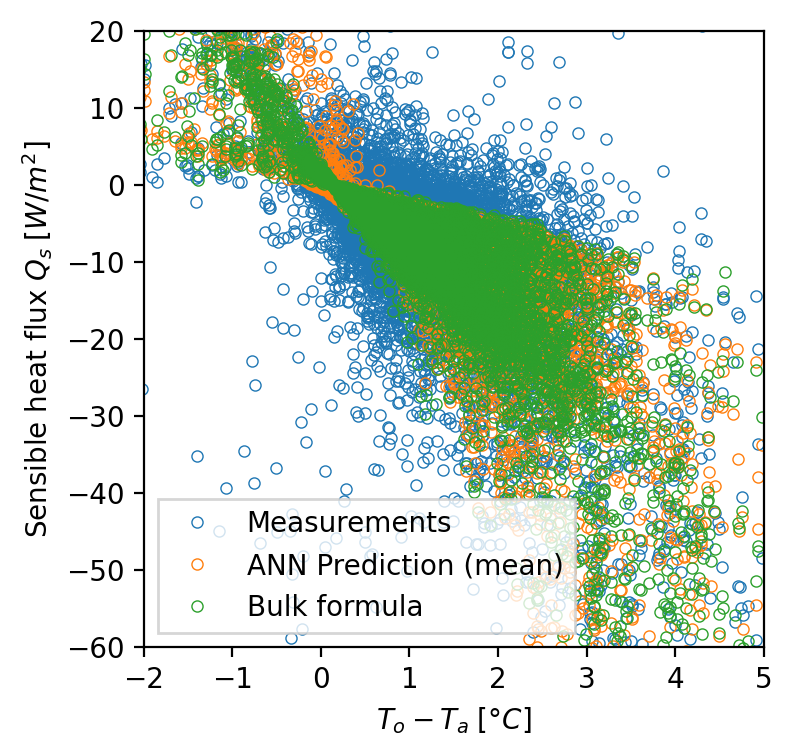

In [31]:
fig = plt.figure(figsize=[4,4],dpi=200); ax = plt.gca()

keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['hsc'], 'bkeys':['hsb']}
vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)
plot_feature(ax, vd.X[:,1]-vd.X[:,2], vd.Y, model.pred_mean(vd.X).detach().numpy())
ax.plot(vd.X[:,1]-vd.X[:,2], vd.Bulk, 'o', mfc="None", markeredgewidth=0.5, markersize=4, label='Bulk formula')
ax.legend(fancybox=False)
ax.set_ylim([-60,20]); ax.set_xlim([-2,5])
ax.set_xlabel('$T_o-T_a \; [\degree C]$'); ax.set_ylabel('Sensible heat flux $Q_s \; [W/m^2]$')

### Reload four-output trained model

In [9]:
''' Predictor with five inputs and four outputs '''
class Flux54(FluxANNs):
    
    @cached_property
    def Xscale(self):
        # mean of x1, mean of x2
        mean = torch.tensor(np.array([0,0,0,0,0]).reshape(1,-1).astype('float32'))
        # std of x1, std of x2 (or scale)
        scale = torch.tensor(np.array([20,20,20,100,0.001]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
        
    @cached_property
    def Yscale(self):
        mean = torch.tensor(np.array([0,0,-8,-90]).reshape(1,-1).astype('float32'))
        scale = torch.tensor(np.array([0.1,0.1,20.,50.]).reshape(1,-1).astype('float32'))
        return {'mean':mean,'scale':scale}
    
    def evaluate_uniform(self):
        pass

''' Predictor with four inputs and four outputs, and with fixed first layer taking temperature difference. '''
from mlflux.ann import ANNdiff   
class Flux54diff(Flux54):
    def __init__(self,params={}):
        super().__init__(params)
        self.mean_func = ANNdiff(**self.mean_ann_para)
        self.var_func = ANNdiff(**self.var_ann_para)     

In [10]:
###### Pick one out of five random weights initialization ######
import pickle

bestrun_list = []

for i in range(3):
    r2_validating_runs = []; r2_training_runs = []; loss_runs = []
    for run in range(5):
        with open('../../saved_model/full_anns/flux54_diff_3layers_split%g_run%g.p' %(i+1, run), 'rb') as pickle_file:
            model = pickle.load(pickle_file)
            r2_training_runs.append(model.log['training_r2'][-1])
            r2_validating_runs.append(model.log['validating_r2'][-1])
            loss_runs.append(model.log['LLLoss'][-1])
        
    r2_training_runs = np.array(r2_training_runs)
    r2_validating_runs = np.array(r2_validating_runs)
    # print(r2_training_runs, r2_validating_runs, loss_runs)
    
    # for ifeature in range(4):
    #     bestrun = r2_validating_runs[:,ifeature].argmax()
    #     print('Best run for feature %g is %g' %(ifeature,bestrun))
    
    ###### Pick best based on some metrics ######
    bestrun = r2_validating_runs[:,2].argmax()
    bestrun_list.append(bestrun)

In [42]:
def plot_feature(ax, X, Y_truth, Y_pred, LEGEND=True):
    mse = torch.mean((Y_truth-Y_pred)**2)
    r2 = 1 - mse/torch.var(Y_truth)
    ax.plot(X,Y_truth, 'o', mfc="None", markeredgewidth=0.5, markersize=4, label='Measurements')
    ax.plot(X,Y_pred, 'o', mfc="None", markeredgewidth=0.5, markersize=4, label='ANN r2=%.3f' %r2)
    if LEGEND:
        ax.legend(fancybox=False)

In [47]:
Ypred[:,i]

array([-110.92981 , -125.37306 , -131.14151 , ...,  -24.296036,
        -36.254776,  -33.53337 ], dtype=float32)

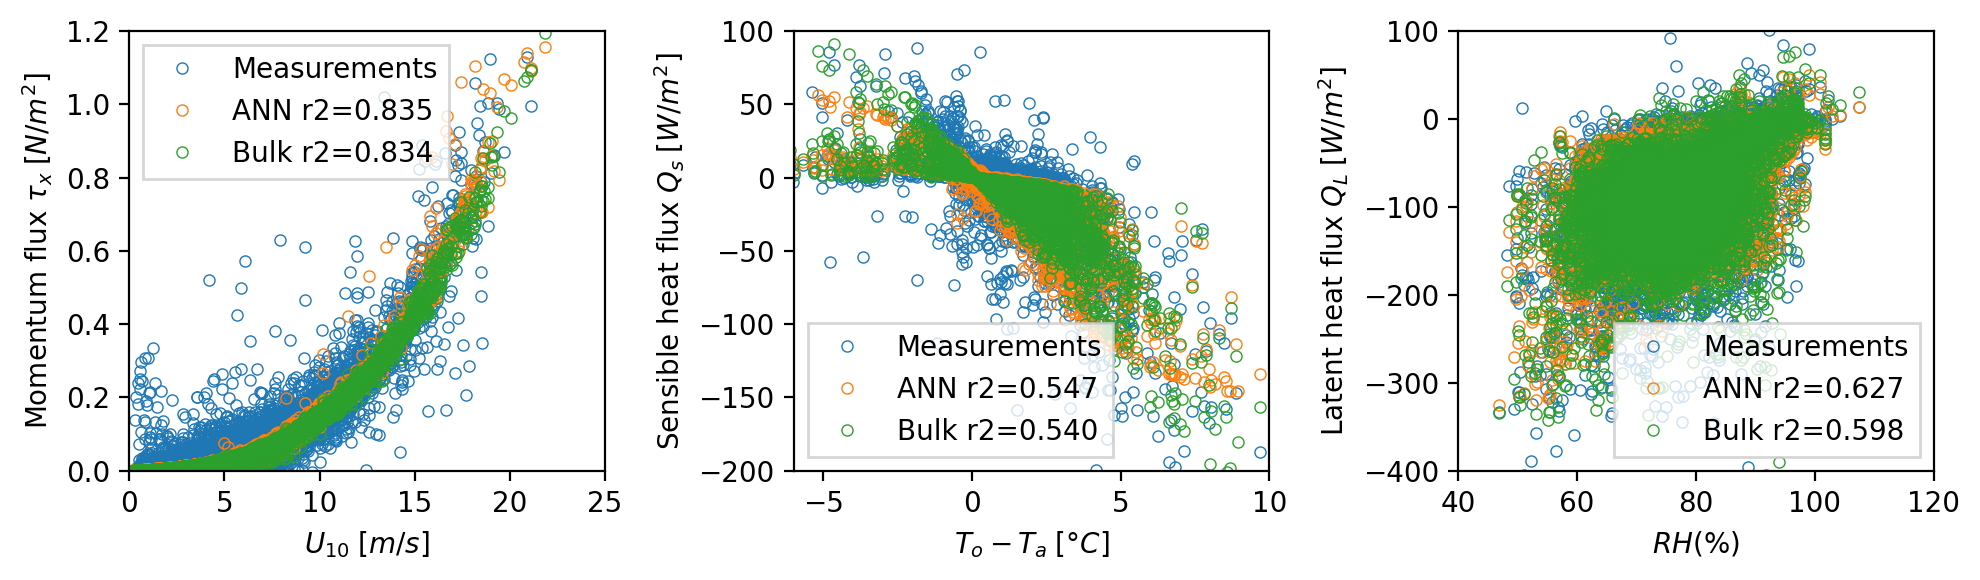

In [50]:
# no weights
def sample_weights(x):
    return np.where(x > 18, 1.0, 1.0)

j = 2
with open('../../saved_model/full_anns/flux54_diff_3layers_split%g_run%g.p' %(j+1, bestrun_list[j]), 'rb') as pickle_file:
    model = pickle.load(pickle_file)

keys = {'ikeys':['U','tsea','tair','rh', 'qair'], 'okeys':['taucx', 'taucy', 'hsc', 'hlc'], 'bkeys':['taubx', 'tauby', 'hsb', 'hlb']}
vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)
Ypred = model.pred_mean(vd.X).detach().numpy()

fig, axes = plt.subplots(1, 3, figsize=[10,3], dpi=200)

xlim = [[0,25], [-6,10], [40,120]]; ylim = [[0,1.2], [-200,100], [-400,100]]
xlabel = [r'$U_{10} \; [m/s]$', r'$T_o-T_a \; [\degree C]$', r'$RH(\%)$']
ylabel = [r'Momentum flux $\tau_x \; [N/m^2]$', r'Sensible heat flux $Q_s \; [W/m^2]$', 'Latent heat flux $Q_L \; [W/m^2]$']

for axi,i in enumerate([0,2,3]):
    ax = axes[axi]
    if i == 0:
        plot_feature(ax, vd.X[:,0], vd.Y[:,i], Ypred[:,i], LEGEND=False)
        mse = torch.mean((vd.Bulk[:,i]-vd.Y[:,i])**2); r2 = 1 - mse/torch.var(vd.Y[:,i])
        ax.plot(vd.X[:,0], vd.Bulk[:,i], 'o', mfc="None", markeredgewidth=0.5, markersize=4, label='Bulk r2=%.3f' %r2)
    elif i == 2:
        plot_feature(ax, vd.X[:,1]-vd.X[:,2], vd.Y[:,i], Ypred[:,i], LEGEND=False)
        mse = torch.mean((vd.Bulk[:,i]-vd.Y[:,i])**2); r2 = 1 - mse/torch.var(vd.Y[:,i])
        ax.plot(vd.X[:,1]-vd.X[:,2], vd.Bulk[:,i], 'o', mfc="None", markeredgewidth=0.5, markersize=4, label='Bulk r2=%.3f' %r2)
    elif i == 3:
        plot_feature(ax, vd.X[:,3], vd.Y[:,i], Ypred[:,i], LEGEND=False)
        mse = torch.mean((vd.Bulk[:,i]-vd.Y[:,i])**2); r2 = 1 - mse/torch.var(vd.Y[:,i])
        ax.plot(vd.X[:,3], vd.Bulk[:,i], 'o', mfc="None", markeredgewidth=0.5, markersize=4, label='Bulk r2=%.3f' %r2)

    ax.set_xlim(xlim[axi]); ax.set_ylim(ylim[axi])
    ax.set_xlabel(xlabel[axi]); ax.set_ylabel(ylabel[axi])    
    ax.legend(fancybox=False)
    
plt.tight_layout()

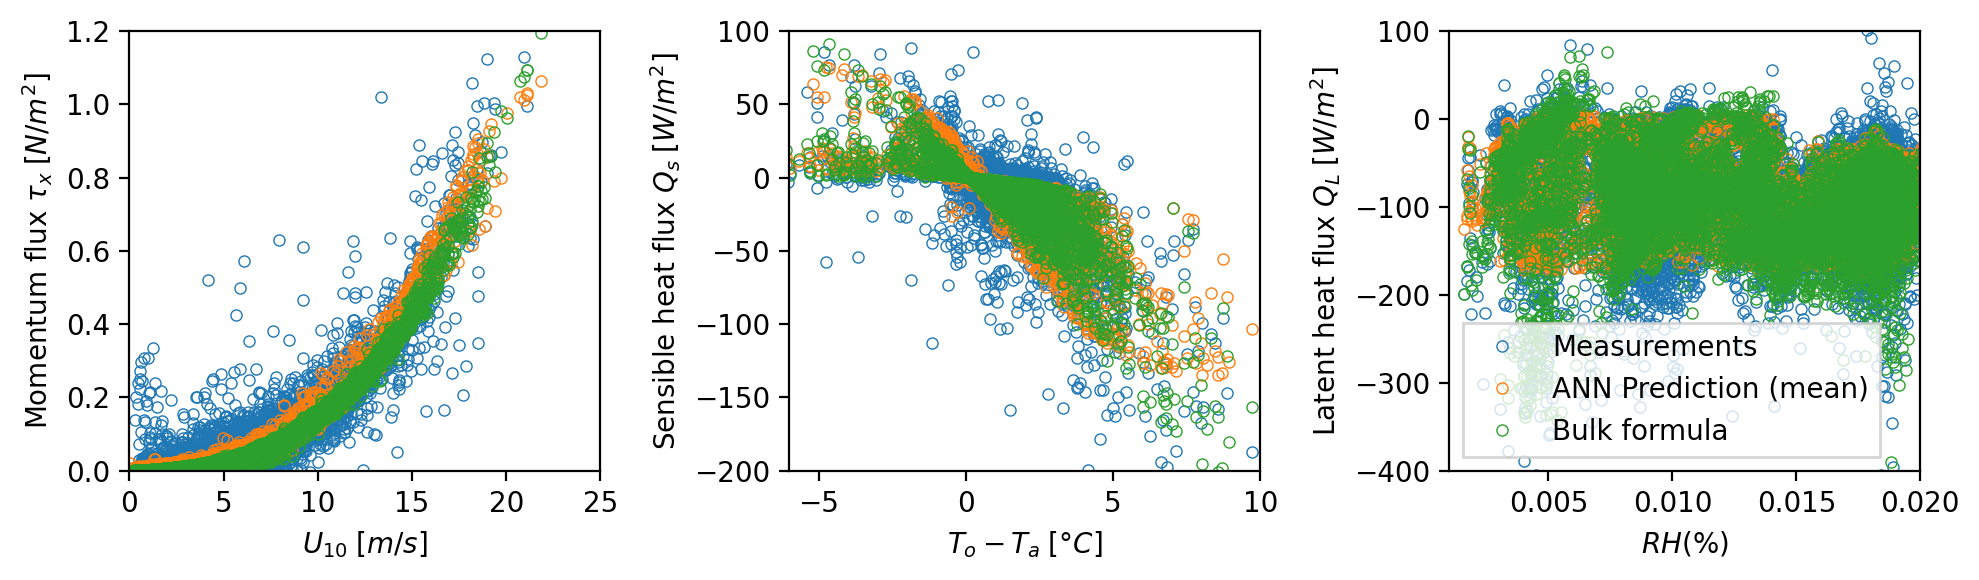

In [13]:
# no weights
def sample_weights(x):
    return np.where(x > 18, 1.0, 1.0)

j = 0
with open('../../saved_model/full_anns/flux54_diff_3layers_split%g_run%g.p' %(j+1, bestrun_list[j]), 'rb') as pickle_file:
    model = pickle.load(pickle_file)
    
keys = {'ikeys':['U','tsea','tair','rh', 'qair'], 'okeys':['taucx', 'taucy', 'hsc', 'hlc'], 'bkeys':['taubx', 'tauby', 'hsb', 'hlb']}
vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)
Ypred = model.pred_mean(vd.X).detach().numpy()

fig, axes = plt.subplots(1, 3, figsize=[10,3], dpi=200)
xlim = [[0,25], [-6,10], [0.001, 0.02]]; ylim = [[0,1.2], [-200,100], [-400,100]]
xlabel = [r'$U_{10} \; [m/s]$', r'$T_o-T_a \; [\degree C]$', r'$RH(\%)$']
ylabel = [r'Momentum flux $\tau_x \; [N/m^2]$', r'Sensible heat flux $Q_s \; [W/m^2]$', 'Latent heat flux $Q_L \; [W/m^2]$']

for i in range(0, 3):
    ax = axes[i]
    if i == 0:
        plot_feature(ax, vd.X[:,0], vd.Y[:,i], Ypred[:,i], LEGEND=False)
        ax.plot(vd.X[:,0], vd.Bulk[:,i], 'o', mfc="None", markeredgewidth=0.5, markersize=4, label='Bulk formula')
    elif i == 1:
        plot_feature(ax, vd.X[:,1]-vd.X[:,2], vd.Y[:,i+1], Ypred[:,i+1], LEGEND=False)
        ax.plot(vd.X[:,1]-vd.X[:,2], vd.Bulk[:,i+1], 'o', mfc="None", markeredgewidth=0.5, markersize=4, label='Bulk formula')
    elif i == 2:
        plot_feature(ax, vd.X[:,4], vd.Y[:,i+1], model.pred_mean(vd.X).detach().numpy()[:,i+1], LEGEND=False)
        ax.plot(vd.X[:,4], vd.Bulk[:,i+1], 'o', mfc="None", markeredgewidth=0.5, markersize=4, label='Bulk formula')

    ax.set_xlim(xlim[i]); ax.set_ylim(ylim[i])
    ax.set_xlabel(xlabel[i]); ax.set_ylabel(ylabel[i])
    
axes[2].legend(fancybox=False)
plt.tight_layout()

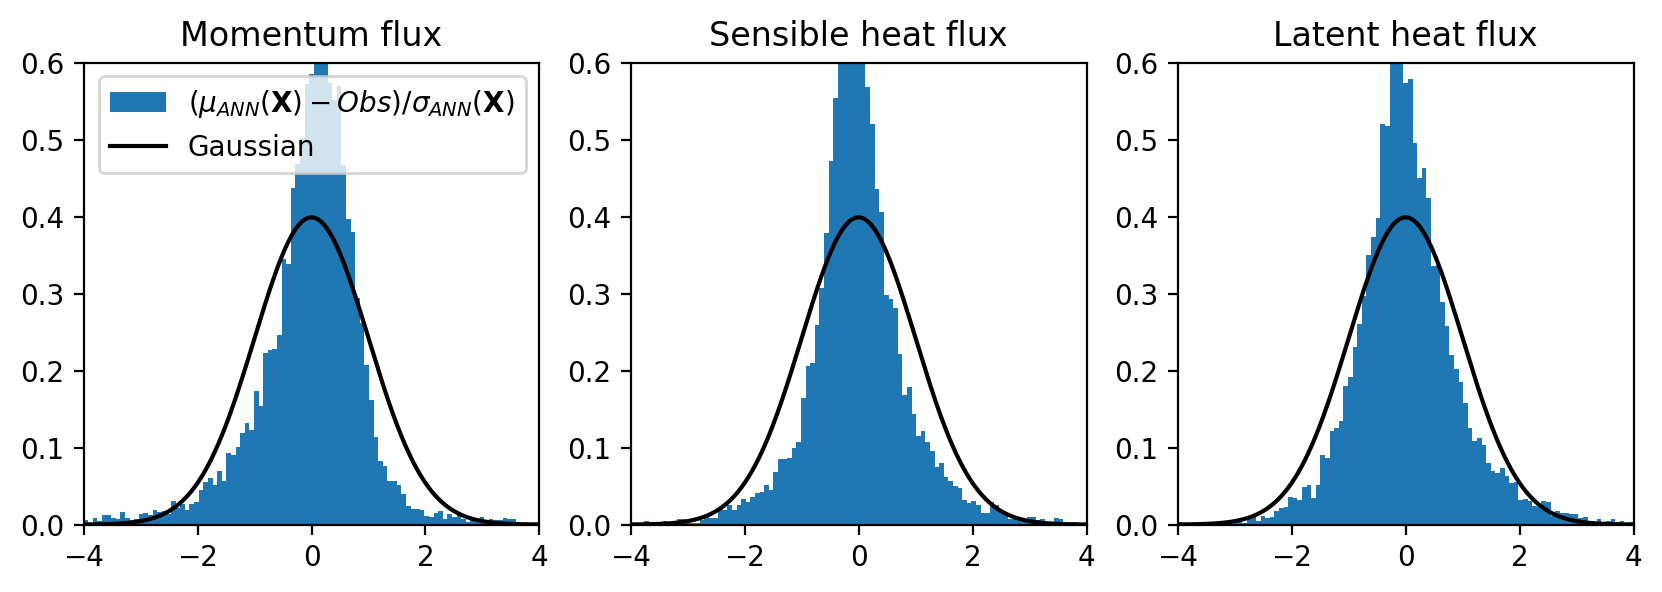

In [25]:
fig, axes = plt.subplots(1, 3, figsize=[10,3], dpi=200)
mu = 0      # mean
sigma = 1   # standard deviation
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
y = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu)/sigma)**2)

j = 1
with open('../../saved_model/full_anns/flux54_diff_3layers_split%g_run%g.p' %(j+1, bestrun_list[j]), 'rb') as pickle_file:
    model = pickle.load(pickle_file)
    
Y_pred = model.pred_mean(vd.X).detach().numpy()
Y_var_pred = model.pred_var(vd.X).detach().numpy()

ylabel = ['Momentum flux', 'Sensible heat flux', 'Latent heat flux']

for axi,i in enumerate([0,2,3]):
    ax = axes[axi]
    error = Ypred[:,i] - vd.Y[:,i].detach().numpy()
    error_norm = error/Y_var_pred[:,i]**0.5
    ax.hist(error_norm, bins=np.linspace(-4, 4, 100), density=True, 
         label='$(\mu_{ANN}(\mathbf{X}) - Obs)/\sigma_{ANN}(\mathbf{X})$')
    ax.plot(x, y, color='k', label='Gaussian')
    ax.set_xlim([-4,4]); ax.set_ylim([0,0.6])
    ax.set_title(ylabel[axi])

axes[0].legend()